In [1]:
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

%matplotlib inline

In [2]:
q = xr.open_dataarray('rico.tn6.q.337.5m.nc', decode_times=False).squeeze()
w = xr.open_dataarray('rico.tn6.w_zt.337.5m.nc', decode_times=False).squeeze()

In [3]:
a = q - q.mean()
b = w - w.mean()

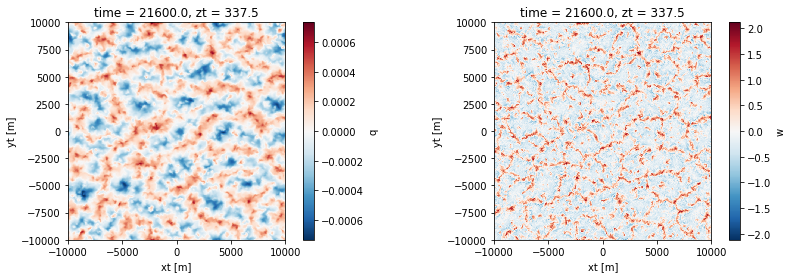

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
a.plot(ax=axes[0])
axes[0].set_aspect(1)
b.plot(ax=axes[1])
axes[1].set_aspect(1)

In [5]:
bb = b*b
aa = a*a

In [6]:
def eta(a_, b_, mask):
    b_s_mean = b_.where(mask).mean()
    a_s_mean = a_.where(mask).mean()
    b_e_mean = b_.where(~mask).mean()
    a_e_mean = a_.where(~mask).mean()
    nx, ny = a_.shape
    sigma = np.count_nonzero(mask)/(nx*ny)
    
    ab_mean = (a_*b_).mean()
    
    return (sigma*a_s_mean*b_s_mean + (1-sigma)*a_e_mean*b_e_mean)/ab_mean

In [7]:
def person(a_, b_):
    return (a_*b_).mean()/np.sqrt((a_*a_).mean())/np.sqrt((b_*b_).mean())

In [8]:
m = b > 1.0
eta(a,a,m), eta(b,b,m), eta(a,b,m), person(a,b)

(<xarray.DataArray ()>
 array(0.07294)
 Coordinates:
     time     float64 2.16e+04
     zt       float32 337.5, <xarray.DataArray 'w' ()>
 array(0.291377)
 Coordinates:
     time     float64 2.16e+04
     zt       float32 337.5, <xarray.DataArray ()>
 array(0.308268)
 Coordinates:
     time     float64 2.16e+04
     zt       float32 337.5, <xarray.DataArray ()>
 array(0.472914, dtype=float32)
 Coordinates:
     time     float64 2.16e+04
     zt       float32 337.5)

In [9]:
ds = xr.Dataset(
    dict(
        a_crit=np.linspace(a.min(), a.max(), 10),
        b_crit=np.linspace(b.min(), b.max(), 10),
    )
)
ds

<xarray.Dataset>
Dimensions:  (a_crit: 10, b_crit: 10)
Coordinates:
  * a_crit   (a_crit) float64 -0.0007339 -0.0005776 ... 0.0005169 0.0006732
  * b_crit   (b_crit) float64 -1.221 -0.8501 -0.4793 ... 1.375 1.746 2.116
Data variables:
    *empty*

In [10]:
import itertools
import tqdm

def apply_all(ds, fn, dims=None):
    """
    Use coordinate dims in ds to provide arguments to fn
    """
    if dims is None:
        dims = ds.coords.keys()

    args = list(itertools.product(*[ds[d].values for d in dims]))
    def process(**kwargs):
        da = fn(**kwargs)
        if da is not None:
            for k, v in kwargs.items():
                da.coords[k] = v
            da = da.expand_dims(kwargs.keys())
        return da

    
    data = [process(**dict(zip(dims,a))) for a in tqdm.tqdm_notebook(args)]
    
    if all([da is None for da in data]):
        return None
    else:
        return xr.merge(data).squeeze()

In [11]:
def run(a_crit, b_crit):
    m = np.logical_and(a > a_crit, b > b_crit)

    return xr.Dataset(
        dict(
            eta_aa=eta(a,a,m), 
            eta_bb=eta(b,b,m),
            eta_ab=eta(a,b,m), 
            person=person(a,b)
        ),
    )

In [12]:
ds_out = apply_all(ds=ds, fn=run)

/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty sli

/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/leifdenby/miniconda3/envs/py3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty sli

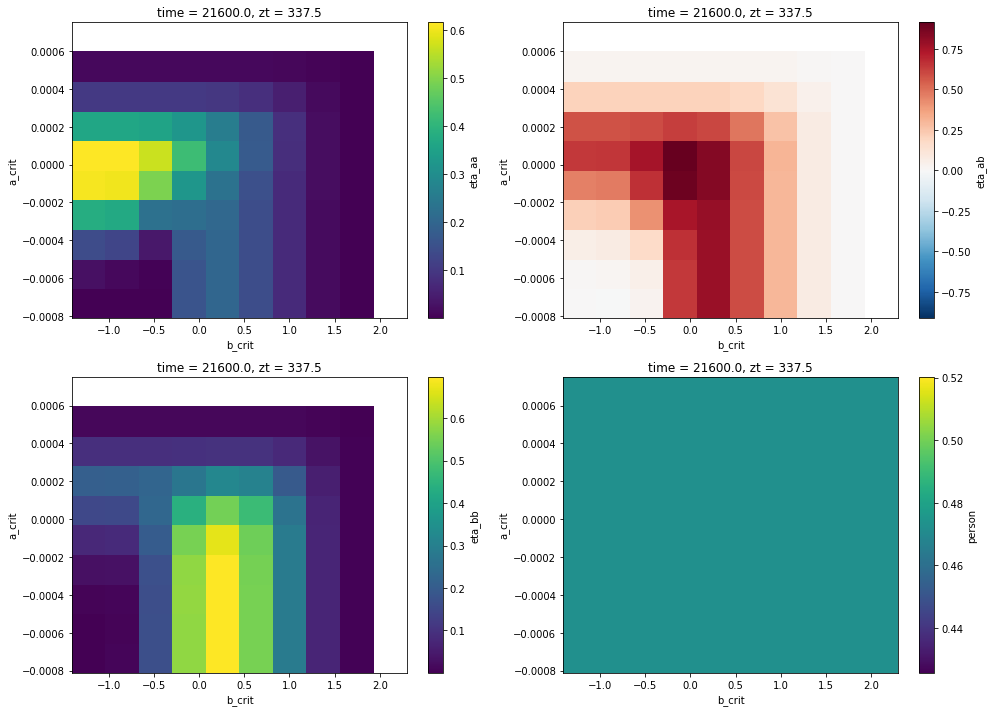

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,10))

ds_out.eta_aa.plot(ax=axes[0][0])
ds_out.eta_bb.plot(ax=axes[1][0])
ds_out.eta_ab.plot(ax=axes[0][1])
ds_out.person.plot(ax=axes[1][1])
plt.tight_layout()